# EDA regarding:
* Tries of balancing future batches on tumor area%
* Justification for smallest feature space in U-Net 

# Install

In [2]:
# !pip install monai-weekly

# Import libraries

In [1]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings


from monai.apps import DecathlonDataset
from monai.data import DataLoader
from monai.transforms import (
    LoadImageD,
    Compose,
    LoadImageD,
)

import torch
import numpy as np
import matplotlib.pyplot as plt
import random


#### Set seeds

In [2]:
import sys
from tqdm import tqdm

In [3]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### Hyperparameters

In [4]:
BATCH_SIZE = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128
COLOUR_CHANNELS = 1
NO_STACKED_IMGS = 5 # number of images to stack for the model (Determined by the average size of the tumour in EDA part 1)

In [6]:
crt_dir = os.getcwd()

datasets_path = f'{crt_dir}/datasets/MedicalDecathlon/'

# Visualize data

## TRAIN

In [9]:
# Set up transform
KEYS = ["image", "label"]

base_transform = Compose([
    LoadImageD(keys=KEYS),
])

In [10]:
import pickle as pkl

with open(f'/home/aimas/Desktop/Disertatie_CataChiru/training_stacks.pkl', 'rb') as f:
    patients = pkl.load(f)


In [12]:
# Load data
train_name = 'training' # From Monai: ['training', 'validation', 'test']
train_dataset = DecathlonDataset(root_dir = f'{datasets_path}{train_name}/',
                           task = "Task06_Lung", section = train_name,
                           transform = base_transform, download = False)

for i in range(len(train_dataset)):
    train_dataset[i]['image'] = train_dataset[i]['image'][:, :, patients[i]]
    train_dataset[i]['label'] = train_dataset[i]['label'][:, :, patients[i]]


train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = False) #, num_workers = 1)

Loading dataset: 100%|██████████| 51/51 [03:26<00:00,  4.05s/it]


In [13]:
for patient_batch in tqdm(train_loader):
    print(patient_batch['image'].shape)
    break


  0%|          | 0/51 [00:00<?, ?it/s]

torch.Size([1, 512, 512, 70])


In [22]:
def average_tumour_surface(crt_loader, print_flag = False):
    '''
    Computes the average number of pixels that the tumour covers in the images of each patient
    '''
    surface_percentage_per_patient = []

    i = 0
    for patient_batch in tqdm(crt_loader):
        label = patient_batch['label']
        percentage_area = np.mean(np.sum(label.cpu().numpy(), axis = (1, 2)))

        surface_percentage_per_patient.append(percentage_area)

        if print_flag:
            print(f"For patient {i} the tumour covers {percentage_area} pixels")
        i += 1

    return surface_percentage_per_patient



In [23]:
avg_tumour_area = average_tumour_surface(train_loader, print_flag = False)

100%|██████████| 51/51 [00:01<00:00, 38.08it/s]


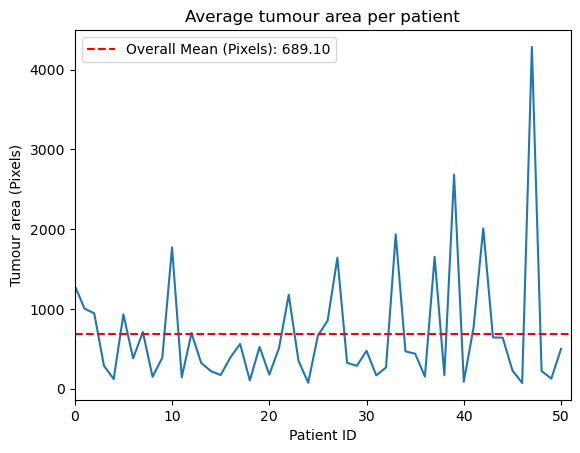

In [25]:
plt.plot(avg_tumour_area)
plt.title('Average tumour area per patient')

# Put the mean value on the plot
mean_tumour_area = np.mean(avg_tumour_area)
plt.axhline(y = mean_tumour_area, color = 'r', linestyle = '--', label = f'Overall Mean (Pixels): {mean_tumour_area:.2f}')



plt.ylabel('Tumour area (Pixels)')
plt.xlabel('Patient ID')
plt.xlim(0, len(avg_tumour_area))
plt.legend()
plt.show()


In [103]:
def tumour_percentages_per_training_batches(crt_loader, NO_STACKED_IMGS):
    '''
    Computes for a specified number of stacked images the percentage of tumour voxels in each batch

    Returns a list of tuples (voxels_with_tumour, percentage_of_tumour_in_batch_volume)
    '''
    percentages_batches = []

    patient_idx = 0
    for patient_batch in tqdm(crt_loader):
        print(f'Patient {patient_idx}')
        patient_label = patient_batch['label'][0].numpy()
        patient_idx += 1

        for i in range(0, patient_label.shape[-1], NO_STACKED_IMGS):
            crt_label = patient_label[:, :, i:i+NO_STACKED_IMGS]

            voxels_with_tumour = np.sum(crt_label)
            volume = np.prod(crt_label.shape)

            percentages_batches.append((voxels_with_tumour, 100*voxels_with_tumour / volume))


    return percentages_batches

In [105]:
percentages_batches_tr = tumour_percentages_per_training_batches(train_loader, NO_STACKED_IMGS)

  2%|▏         | 1/51 [00:00<00:05,  9.39it/s]

Patient 0
Patient 1
Patient 2
Patient 3
Patient 4
Patient 5


 22%|██▏       | 11/51 [00:00<00:01, 30.42it/s]

Patient 6
Patient 7
Patient 8
Patient 9
Patient 10
Patient 11
Patient 12
Patient 13
Patient 14
Patient 15


 43%|████▎     | 22/51 [00:00<00:00, 40.54it/s]

Patient 16
Patient 17
Patient 18
Patient 19
Patient 20
Patient 21
Patient 22
Patient 23
Patient 24
Patient 25


 55%|█████▍    | 28/51 [00:00<00:00, 36.58it/s]

Patient 26
Patient 27
Patient 28
Patient 29
Patient 30
Patient 31
Patient 32


 73%|███████▎  | 37/51 [00:01<00:00, 34.95it/s]

Patient 33
Patient 34
Patient 35
Patient 36
Patient 37
Patient 38
Patient 39


 88%|████████▊ | 45/51 [00:01<00:00, 31.46it/s]

Patient 40
Patient 41
Patient 42
Patient 43
Patient 44
Patient 45
Patient 46


100%|██████████| 51/51 [00:01<00:00, 33.91it/s]

Patient 47
Patient 48
Patient 49
Patient 50


In [106]:
percentages_batches_tr

[(985.0, 0.0751495361328125),
 (2991.0, 0.2281951904296875),
 (5110.0, 0.389862060546875),
 (7864.0, 0.5999755859375),
 (9937.0, 0.7581329345703125),
 (10831.0, 0.8263397216796875),
 (10467.0, 0.7985687255859375),
 (9790.0, 0.746917724609375),
 (8783.0, 0.6700897216796875),
 (7537.0, 0.5750274658203125),
 (6386.0, 0.487213134765625),
 (5012.0, 0.38238525390625),
 (3644.0, 0.27801513671875),
 (1098.0, 0.083770751953125),
 (1029.0, 0.0785064697265625),
 (6568.0, 0.5010986328125),
 (11273.0, 0.8600616455078125),
 (9017.0, 0.6879425048828125),
 (6839.0, 0.5217742919921875),
 (5025.0, 0.3833770751953125),
 (1067.0, 0.0814056396484375),
 (300.0, 0.02288818359375),
 (25.0, 0.0095367431640625),
 (988.0, 0.07537841796875),
 (3124.0, 0.23834228515625),
 (5841.0, 0.4456329345703125),
 (7669.0, 0.5850982666015625),
 (7908.0, 0.60333251953125),
 (3546.0, 0.270538330078125),
 (202.0, 0.077056884765625),
 (828.0, 0.06317138671875),
 (2340.0, 0.17852783203125),
 (1565.0, 0.1194000244140625),
 (150.0, 

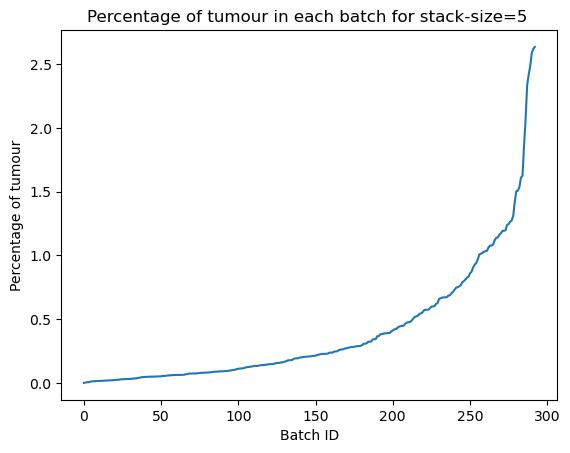

In [107]:
percentages_only_tr = np.array([perc[1] for perc in percentages_batches_tr])
percentages_only_tr = sorted(percentages_only_tr)
plt.plot(percentages_only_tr)
plt.title(f'Percentage of tumour in each batch for stack-size={NO_STACKED_IMGS} ')
plt.xlabel('Batch ID')
plt.ylabel('Percentage of tumour')
plt.show()

In [188]:
len(percentages_only_tr)

293

In [186]:
# Tried to find a way of binning the percentages so that the distribution is somewhat even
# Using logarithmic bins oversaturates 2 bins and leaves the rest empty
# Using linear bins does not work either
# Neither does using 1/x bins
# It looks like it is 1/x up to one point and then a polynomial function

bins = [0] + [1/x for x in [1,2,3,4,5,6,7,8]] + [2]

bins = sorted(bins)
print(bins)
frequencies = {bin: 0 for bin in bins}


for perc in percentages_only_tr:
    for i in range(len(bins) + 1):
        # print(perc, bins[i])
        if i + 1 == len(bins):
            frequencies[bins[i]] += 1
            break
        elif perc < bins[i + 1]:
            frequencies[bins[i]] += 1
            break

frequencies

[0, 0.125, 0.14285714285714285, 0.16666666666666666, 0.2, 0.25, 0.3333333333333333, 0.5, 1.0, 2]


{0: 107,
 0.125: 11,
 0.14285714285714285: 12,
 0.16666666666666666: 10,
 0.2: 25,
 0.25: 22,
 0.3333333333333333: 26,
 0.5: 43,
 1.0: 30,
 2: 7}

In [190]:
sum(frequencies.values())

293

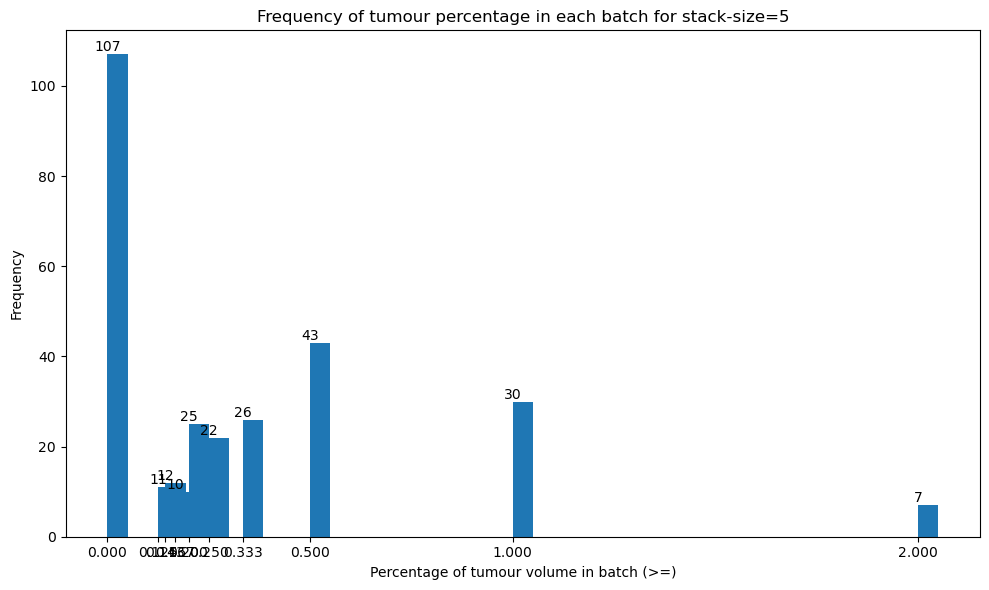

In [187]:
# frequencies = np.linspace(0, 3, 10)

# Logarithmic scale histogram

plt.figure(figsize=(10, 6))
plt.bar(bins, frequencies.values(), align='edge', width=0.05)

# Put count on top of the bars
for i in range(len(bins)):
    plt.text(bins[i], frequencies[bins[i]], str(frequencies[bins[i]]), ha='center', va='bottom')
plt.xticks(bins)

plt.title(f'Frequency of tumour percentage in each batch for stack-size={NO_STACKED_IMGS}')
plt.xlabel('Percentage of tumour volume in batch (>=)')
# plt.x
plt.ylabel('Frequency')

#Tight layout
plt.tight_layout()
# plt.gca().set_xscale("log")
plt.show()

In [157]:
def hyperparam_tuning_no_stacks(crt_loader, finetune_zero_batches = False, finetune_tumour_percentage = False):
    '''
    Iterates over a range of stack sizes and computes:
    - The number of batches with 0% tumour if finetune_zero_batches is True
        In this set-up, it will stop when the number of batches with 0% tumour starts increasing
        We want to minimize the number of batches with 0% tumour, because it poissons the training

    - The average percentage volume of tumour in each batch if finetune_tumour_percentage is True
        Once preprocessing is done on the dataset, we want a stack size that has a good distribution of tumour percentages
        We keep track of the total number of batches for each stack size, as it is easier to have a higher percentage of tumour in a smaller batch
        We want to maximize the average percentage of tumour in each batch, taking into account the total number of batches
    '''

    max_stack = 64
    NO_STACKED_IMGS_RANGE = range(3, max_stack+1)

    no_zero_batches, tumour_percentage = [], []

    for crt_no_stacks in NO_STACKED_IMGS_RANGE:
        print(f'Running for stack size: {crt_no_stacks}/{max_stack}')

        zero_batches = 0
        total_batches = 0
        tumour_percentage_in_batch = []

        for patient_batch in tqdm(crt_loader):
            patient_label = patient_batch['label'][0].numpy()

            for i in range(0, patient_label.shape[-1], crt_no_stacks):
                crt_label = patient_label[:, :, i:i+crt_no_stacks]

                if finetune_zero_batches:
                    zero_batches += (np.sum(crt_label) == 0)

                if finetune_tumour_percentage:
                    tumour_percentage_in_batch.append(100*np.sum(crt_label) / np.prod(crt_label.shape))
    
                total_batches += 1

        tumour_percentage_in_batch = np.mean(tumour_percentage_in_batch)
        if finetune_tumour_percentage:
            tumour_percentage.append((crt_no_stacks, tumour_percentage_in_batch, total_batches))

        # if len(no_zero_batches) !=0:
        #     # Daca am pentru un numar de stackuri mai multe batchuri cu 0% tumour decat pentru numarul anterior, atunci ma opresc pentru ca deja baga prea multe 0-uri
        #     if zero_batches > no_zero_batches[-1] + 50:
        #         no_zero_batches.append(zero_batches)
        #     else:
        #         no_zero_batches.append(no_zero_batches[-1])

        if finetune_tumour_percentage:
            no_zero_batches.append((crt_no_stacks, zero_batches, total_batches))


    return no_zero_batches, tumour_percentage

In [74]:
no_zero_batches, tumour_percentage = hyperparam_tuning_no_stacks(train_loader, finetune_zero_batches=False, finetune_tumour_percentage=True)

Running for stack size: 3/64


100%|██████████| 51/51 [00:02<00:00, 24.97it/s]


Running for stack size: 4/64


100%|██████████| 51/51 [00:01<00:00, 30.76it/s]


Running for stack size: 5/64


100%|██████████| 51/51 [00:01<00:00, 33.95it/s]


Running for stack size: 6/64


100%|██████████| 51/51 [00:01<00:00, 38.59it/s]


Running for stack size: 7/64


100%|██████████| 51/51 [00:01<00:00, 42.09it/s]


Running for stack size: 8/64


100%|██████████| 51/51 [00:01<00:00, 43.17it/s]


Running for stack size: 9/64


100%|██████████| 51/51 [00:01<00:00, 45.50it/s]


Running for stack size: 10/64


100%|██████████| 51/51 [00:01<00:00, 47.54it/s]


Running for stack size: 11/64


100%|██████████| 51/51 [00:01<00:00, 48.55it/s]


Running for stack size: 12/64


100%|██████████| 51/51 [00:00<00:00, 51.47it/s]


Running for stack size: 13/64


100%|██████████| 51/51 [00:00<00:00, 55.20it/s]


Running for stack size: 14/64


100%|██████████| 51/51 [00:00<00:00, 57.47it/s]


Running for stack size: 15/64


100%|██████████| 51/51 [00:00<00:00, 60.77it/s]


Running for stack size: 16/64


100%|██████████| 51/51 [00:00<00:00, 57.05it/s]


Running for stack size: 17/64


100%|██████████| 51/51 [00:00<00:00, 58.65it/s]


Running for stack size: 18/64


100%|██████████| 51/51 [00:00<00:00, 60.75it/s]


Running for stack size: 19/64


100%|██████████| 51/51 [00:00<00:00, 60.90it/s]


Running for stack size: 20/64


100%|██████████| 51/51 [00:00<00:00, 66.57it/s]


Running for stack size: 21/64


100%|██████████| 51/51 [00:00<00:00, 66.08it/s]


Running for stack size: 22/64


100%|██████████| 51/51 [00:00<00:00, 65.45it/s]


Running for stack size: 23/64


100%|██████████| 51/51 [00:00<00:00, 64.86it/s]


Running for stack size: 24/64


100%|██████████| 51/51 [00:00<00:00, 69.84it/s]


Running for stack size: 25/64


100%|██████████| 51/51 [00:00<00:00, 67.17it/s]


Running for stack size: 26/64


100%|██████████| 51/51 [00:00<00:00, 70.27it/s]


Running for stack size: 27/64


100%|██████████| 51/51 [00:00<00:00, 71.00it/s]


Running for stack size: 28/64


100%|██████████| 51/51 [00:00<00:00, 72.02it/s]


Running for stack size: 29/64


100%|██████████| 51/51 [00:00<00:00, 68.84it/s]


Running for stack size: 30/64


100%|██████████| 51/51 [00:00<00:00, 69.42it/s]


Running for stack size: 31/64


100%|██████████| 51/51 [00:00<00:00, 71.13it/s]


Running for stack size: 32/64


100%|██████████| 51/51 [00:00<00:00, 73.50it/s]


Running for stack size: 33/64


100%|██████████| 51/51 [00:00<00:00, 73.96it/s]


Running for stack size: 34/64


100%|██████████| 51/51 [00:00<00:00, 75.85it/s]


Running for stack size: 35/64


100%|██████████| 51/51 [00:00<00:00, 77.65it/s]


Running for stack size: 36/64


100%|██████████| 51/51 [00:00<00:00, 79.81it/s]


Running for stack size: 37/64


100%|██████████| 51/51 [00:00<00:00, 76.19it/s]


Running for stack size: 38/64


100%|██████████| 51/51 [00:00<00:00, 81.38it/s]


Running for stack size: 39/64


100%|██████████| 51/51 [00:00<00:00, 81.40it/s]


Running for stack size: 40/64


100%|██████████| 51/51 [00:00<00:00, 83.21it/s]


Running for stack size: 41/64


100%|██████████| 51/51 [00:00<00:00, 86.90it/s]


Running for stack size: 42/64


100%|██████████| 51/51 [00:00<00:00, 85.45it/s]


Running for stack size: 43/64


100%|██████████| 51/51 [00:00<00:00, 83.22it/s]


Running for stack size: 44/64


100%|██████████| 51/51 [00:00<00:00, 84.43it/s]


Running for stack size: 45/64


100%|██████████| 51/51 [00:00<00:00, 84.38it/s]


Running for stack size: 46/64


100%|██████████| 51/51 [00:00<00:00, 87.38it/s]


Running for stack size: 47/64


100%|██████████| 51/51 [00:00<00:00, 86.68it/s] 


Running for stack size: 48/64


100%|██████████| 51/51 [00:00<00:00, 85.23it/s]


Running for stack size: 49/64


100%|██████████| 51/51 [00:00<00:00, 83.96it/s]


Running for stack size: 50/64


100%|██████████| 51/51 [00:00<00:00, 87.57it/s]


Running for stack size: 51/64


100%|██████████| 51/51 [00:00<00:00, 85.96it/s] 


Running for stack size: 52/64


100%|██████████| 51/51 [00:00<00:00, 86.63it/s]


Running for stack size: 53/64


100%|██████████| 51/51 [00:00<00:00, 81.28it/s]


Running for stack size: 54/64


100%|██████████| 51/51 [00:00<00:00, 82.98it/s]


Running for stack size: 55/64


100%|██████████| 51/51 [00:00<00:00, 85.01it/s]


Running for stack size: 56/64


100%|██████████| 51/51 [00:00<00:00, 81.07it/s]


Running for stack size: 57/64


100%|██████████| 51/51 [00:00<00:00, 85.84it/s]


Running for stack size: 58/64


100%|██████████| 51/51 [00:00<00:00, 77.56it/s]


Running for stack size: 59/64


100%|██████████| 51/51 [00:00<00:00, 86.33it/s]


Running for stack size: 60/64


100%|██████████| 51/51 [00:00<00:00, 89.35it/s] 


Running for stack size: 61/64


100%|██████████| 51/51 [00:00<00:00, 86.94it/s] 


Running for stack size: 62/64


100%|██████████| 51/51 [00:00<00:00, 88.84it/s] 


Running for stack size: 63/64


100%|██████████| 51/51 [00:00<00:00, 85.30it/s] 


Running for stack size: 64/64


100%|██████████| 51/51 [00:00<00:00, 83.10it/s]


In [75]:
no_zero_batches

[(3, 0, 474),
 (4, 0, 364),
 (5, 0, 293),
 (6, 0, 252),
 (7, 0, 212),
 (8, 0, 195),
 (9, 0, 175),
 (10, 0, 161),
 (11, 0, 147),
 (12, 0, 138),
 (13, 0, 131),
 (14, 0, 116),
 (15, 0, 110),
 (16, 0, 106),
 (17, 0, 104),
 (18, 0, 98),
 (19, 0, 94),
 (20, 0, 90),
 (21, 0, 85),
 (22, 0, 84),
 (23, 0, 83),
 (24, 0, 81),
 (25, 0, 79),
 (26, 0, 78),
 (27, 0, 76),
 (28, 0, 74),
 (29, 0, 73),
 (30, 0, 72),
 (31, 0, 71),
 (32, 0, 70),
 (33, 0, 70),
 (34, 0, 70),
 (35, 0, 65),
 (36, 0, 64),
 (37, 0, 63),
 (38, 0, 63),
 (39, 0, 63),
 (40, 0, 61),
 (41, 0, 60),
 (42, 0, 59),
 (43, 0, 59),
 (44, 0, 58),
 (45, 0, 58),
 (46, 0, 58),
 (47, 0, 58),
 (48, 0, 58),
 (49, 0, 58),
 (50, 0, 58),
 (51, 0, 58),
 (52, 0, 58),
 (53, 0, 58),
 (54, 0, 58),
 (55, 0, 57),
 (56, 0, 57),
 (57, 0, 57),
 (58, 0, 57),
 (59, 0, 57),
 (60, 0, 56),
 (61, 0, 56),
 (62, 0, 56),
 (63, 0, 56),
 (64, 0, 56)]

In [76]:
tumour_percentage

[(3, 0.4124845298198373, 474),
 (4, 0.4046956261435708, 364),
 (5, 0.40269146464654887, 293),
 (6, 0.39292973816079435, 252),
 (7, 0.39891403640376905, 212),
 (8, 0.3841048765822936, 195),
 (9, 0.3821015814264345, 175),
 (10, 0.37694435811637483, 161),
 (11, 0.3778963554915485, 147),
 (12, 0.37128222817112366, 138),
 (13, 0.3637288388864529, 131),
 (14, 0.3767440528048609, 116),
 (15, 0.3742708100838468, 110),
 (16, 0.36868766551864357, 106),
 (17, 0.3569438795615966, 104),
 (18, 0.35766990356624884, 98),
 (19, 0.3572800282781391, 94),
 (20, 0.3576171996835005, 90),
 (21, 0.36491224918045945, 85),
 (22, 0.3569200195610781, 84),
 (23, 0.34725589074501517, 83),
 (24, 0.3448871762538468, 81),
 (25, 0.34064394984783314, 79),
 (26, 0.3350451218694093, 78),
 (27, 0.33304750457849347, 76),
 (28, 0.33431132581079154, 74),
 (29, 0.33208903100220155, 73),
 (30, 0.3270903116427179, 72),
 (31, 0.3244181945499723, 71),
 (32, 0.3214164291076209, 70),
 (33, 0.3137235451959783, 70),
 (34, 0.3050564553

In [77]:
def plot_hyperparam_tuning(crt_evaluation_metric, title_txt, xlabel_txt, ylabel_txt):
    '''
    For the evolution of stack_size on x-axis, it plots the evolution of the evaluation metric on the y-axis
    '''

    analysis_range = [elem[0] for elem in crt_evaluation_metric]
    mean_percentages = [100*elem[1]/elem[2] for elem in crt_evaluation_metric]

    plt.figure(figsize=(30, 5))
    plt.plot(analysis_range, mean_percentages)
    plt.title(title_txt)
    plt.xlabel(xlabel_txt)
    plt.ylabel(ylabel_txt)
    plt.xticks(analysis_range)
    plt.show()

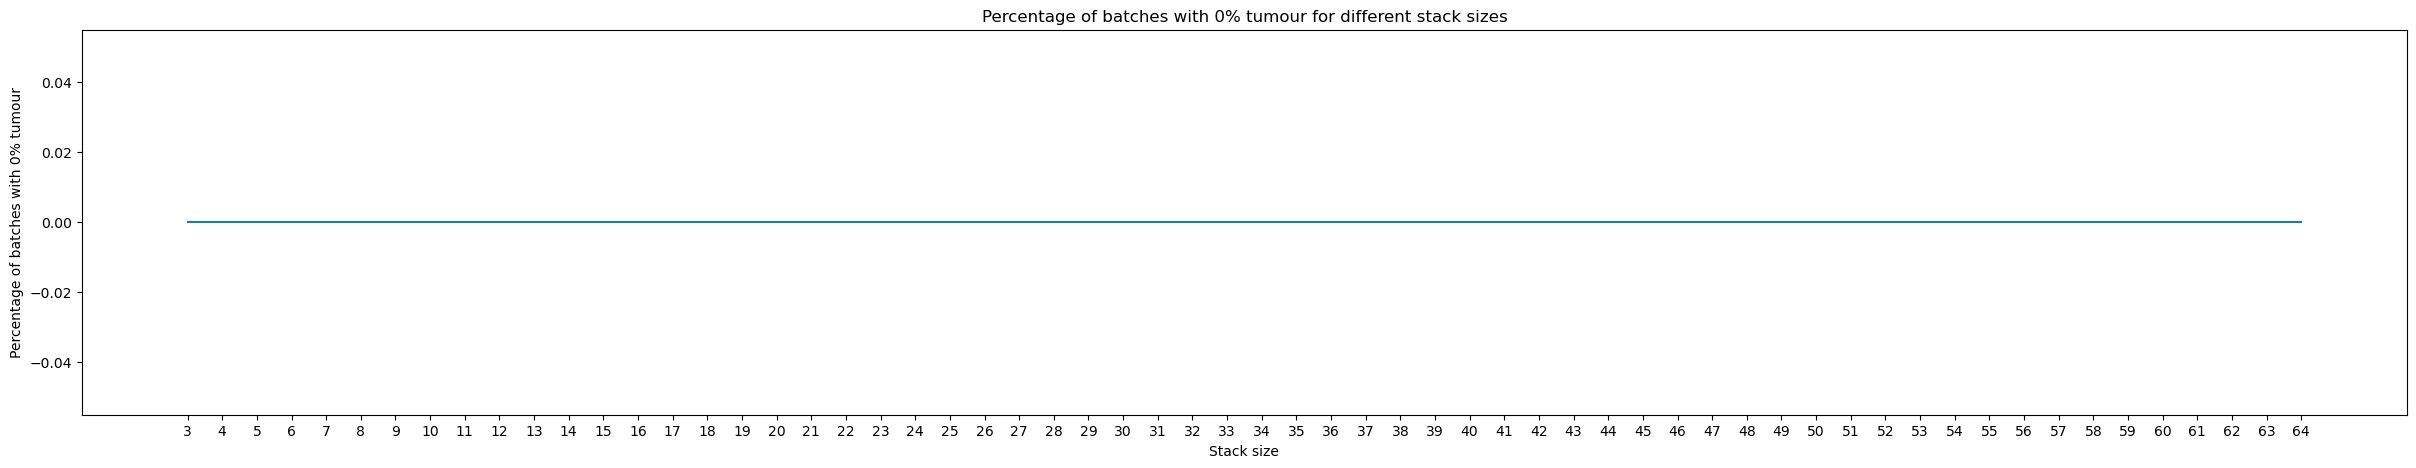

In [78]:
plot_hyperparam_tuning(no_zero_batches, 'Percentage of batches with 0% tumour for different stack sizes', 'Stack size', 'Percentage of batches with 0% tumour')

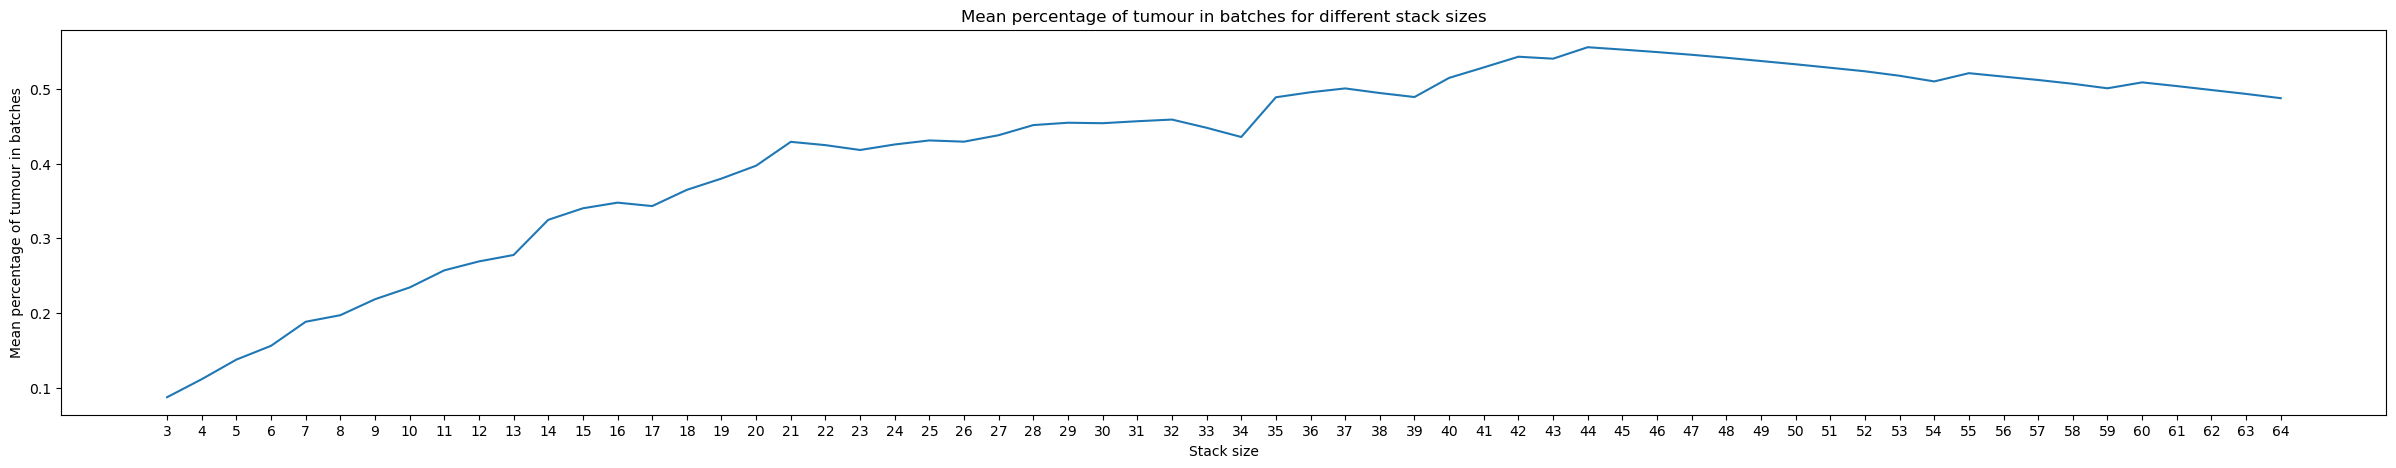

In [79]:
plot_hyperparam_tuning(tumour_percentage, 'Mean percentage of tumour in batches for different stack sizes', 'Stack size', 'Mean percentage of tumour in batches')

In [66]:
# Create a pandas dataframe with the results
# Saves the computational effort of running the notebook again
# It is also easier to visualize the results in a table
import pandas as pd

df = pd.DataFrame(tumour_percentage, columns = ['Stack size', 'Mean percentage of tumour in batches', 'Total batches'])

df

,Stack size,Mean percentage of tumour in batches,Total batches
0,3,0.412485,474
1,4,0.404696,364
2,5,0.402691,293
3,6,0.392930,252
4,7,0.398914,212
5,8,0.384105,195
6,9,0.382102,175
7,10,0.376944,161
8,11,0.377896,147
9,12,0.371282,138
